In [1]:
import MDAnalysis as mda
from MDAnalysis.lib import distances
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.fft import fft, fftfreq

input="input.vib"

commd1 = []
commd2 = []
with open(input, "r") as file:
    after_first_flag = False  # Track if we're after the first '\'

    # Iterate over the file line by line
    for command in file:
        command = command.strip()  # read commands from the begining (Remove extra spaces or newlines)       
        # Check if the current line is the flag '\'
        if command == "\\":
            after_first_flag = True  # Switch to storing in commd2 after first '\'
            continue  # Skip the flag line itself       
        # Store the commands based on the flag location
        if after_first_flag:
            commd2.append(command)
        else:
            commd1.append(command)

for cmd in commd1:            #load files and input parameters from input.vib
    exec(cmd)    
# Load your trajectory and topology files
u = mda.Universe(pdb_file, traj_file)
# Print the unique segids and residue names to identify sugars
unique_segids = set(atom.segid for atom in u.atoms)
unique_residues = set(atom.resname for atom in u.atoms)
print("Unique SegIDs:", unique_segids)
print("Unique Residues:", unique_residues)

for cmd in commd2:         #load selected atoms or units from input.vib
    exec(cmd)

# Command line examples for selection of the units:
#selection1 = u.select_atoms("segid CARA and resnum 1 and name O6")
#selection1 = u.select_atoms("segid CARB and resnum 1")
#selection1 = u.select_atoms("segid PROA and resname ASP and resid 239")
#selection1 = u.select_atoms("segid PROA")
#
#selection2 = u.select_atoms("segid CARC and resnum 4 and name HO6")
#selection2 = u.select_atoms("segid CARC and resnum 4")
#selection2 = u.select_atoms("segid PROC and resname LYS and resid 138")
#selection2 = u.select_atoms("segid PROC")


Unique SegIDs: {'CARB', 'CARA', 'PROB', 'PROA', 'CARD', 'PROC', 'CARC'}
Unique Residues: {'ASN', 'AFUC', 'PRO', 'GLY', 'LYS', 'ARG', 'GLN', 'ALA', 'CYS', 'BGAL', 'TRP', 'ILE', 'THR', 'SER', 'TYR', 'AMAN', 'BMAN', 'VAL', 'PHE', 'BGLC', 'MET', 'GLU', 'ASP', 'LEU', 'HIS'}


Distance between centers of mass running ..... 
done
Average over all traj. : 28.534921747040705
Distances between centers of mass saved in distance.dat
Autocorrelation function & FFT running ...
segment 1     iter [ 2250 , 2500 ]
done
segment 2     iter [ 2500 , 2750 ]
done
segment 3     iter [ 2750 , 3000 ]
done
segment 4     iter [ 3000 , 3250 ]
done
segment 5     iter [ 3250 , 3500 ]
done
segment 6     iter [ 3500 , 3750 ]
done
segment 7     iter [ 3750 , 4000 ]
done
segment 8     iter [ 4000 , 4250 ]
done
segment 9     iter [ 4250 , 4500 ]
done
segment 10     iter [ 4500 , 4750 ]
done
segment 11     iter [ 4750 , 5000 ]
done


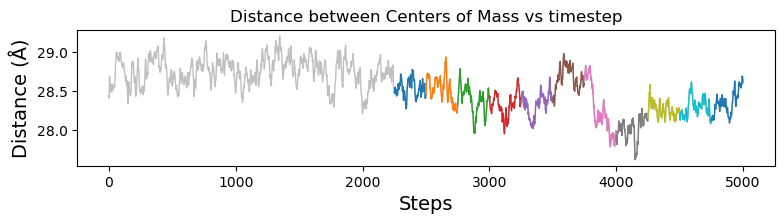

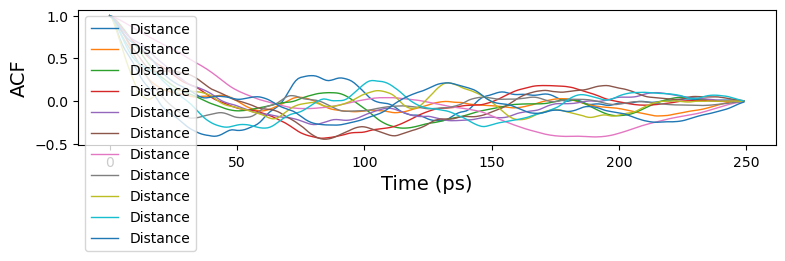

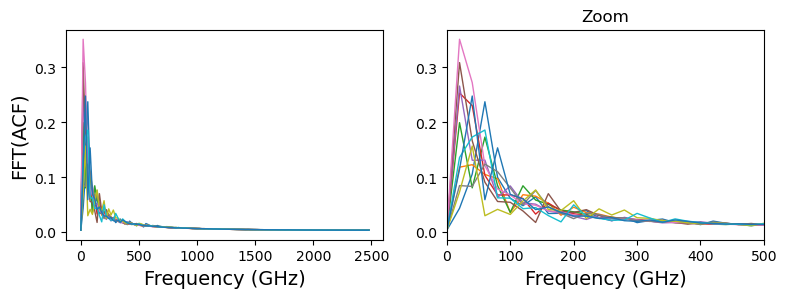

In [2]:
print('Distance between centers of mass running ..... ')

# Calculate the center of mass for each frame  (or type 'compound='residues')
com_selection1 = np.array([selection1.center_of_mass(compound='group') for ts in u.trajectory])
com_selection2 = np.array([selection2.center_of_mass(compound='group') for ts in u.trajectory])

#print(np.shape(com_selection1))

# Reshape the arrays for the distance calculation
com_selection1_reshaped = com_selection1.reshape((len(com_selection1), 3))
com_selection2_reshaped = com_selection2.reshape((len(com_selection2), 3))


# Calculate distances between centers of mass for each frame
distances_array = mda.lib.distances.distance_array(com_selection1_reshaped, com_selection2_reshaped, \
                                                   box=u.dimensions)

# Calculate the distance between the two selected elements
distances=np.diag(distances_array)
print("done")
# Print the average distances
average_distances = np.mean(distances_array, axis=1)
print("Average over all traj. :",np.mean(average_distances))
print("Distances between centers of mass saved in \033[1mdistance.dat\033[0m")

np.savetxt('data/distance.dat', distances)

#################" ACF Calculation
print('Autocorrelation function & FFT running ...')

yraw_all=[]
yac_all=[]
yacf_all=[]
time_all=[]
steps_all=[]

if not 'traj_segments' in locals():
    traj_segments=1

for i in range(0,traj_segments) :
    
    if i==0 :                       # check inpout variables 
        # distance.dat obtained above
        fname='data/distance.dat'   
        dat=np.loadtxt(fname, delimiter=' ', dtype = float)
        yraw_full=dat[0:len(dat)]
        #check trajectory parameters defined (or not) in input.vib
        if not 'traj_min' in locals():
            traj_min=0
        if traj_segments==1 and not 'dtraj' in locals():
            dtraj=len(dat)
        traj_max=traj_min+dtraj
        if traj_max > len(dat):
            traj_max=len(dat)
        if not 'dt' in locals():
            print("\033[1mWARNING\033[0m : timestep 'dt' not defined, set to default (0.2ns)")
            dt=0.2 # timestep in ns
    
    
    print("segment",i+1,"    iter [",traj_min,",",traj_max,"]")
    
    time_full=[ts.time for ts in u.trajectory]  #time    
    time=time_full[traj_min:traj_max]
    time_all.append(time)
    time_from_zero=np.arange(0,dtraj)
    
    steps_full=np.arange(0,len(yraw_full))
    steps=steps_full[traj_min:traj_max]
    steps_all.append(steps)
    
    
    yraw=dat[traj_min:traj_max]                 #raw distances                     
    yraw_all.append(yraw)
    N=len(yraw)


    
    # Calculate ACF
    yac = sm.tsa.acf(yraw, nlags=2*N-1)         # acf of distances
    yac_all.append(yac)
    xacf=fftfreq(N,dt)[:N//2]                   # FFT(acf)   
    yacf=fft(yac)                               #freqmax=(1/dt)/2 : dt= en ns => freq en GHZ
    yacf=yacf[0:N//2]
    yacf_all.append(yacf)

    traj_min=traj_min+dtraj
    traj_max=traj_max+dtraj
    print("done")

# Create a figure for all XY plots
plt.figure(figsize=(9, 6))

label="Distance"
plt.subplot(3,1,1)              # Distances
plt.plot(steps_full,yraw_full,marker='',linestyle='-', label=label, linewidth=1,color='silver')
for i in range(0,traj_segments) :
    plt.plot(steps_all[i], yraw_all[i], marker='', linestyle='-', label=label, linewidth=1,)
i=1
plt.title("Distance between Centers of Mass vs timestep")
plt.ylabel("Distance (Å)", fontsize=14)
plt.xlabel("Steps", fontsize=14)

plt.figure(figsize=(9, 6))       # ACF
plt.subplot(3,1,1)
for i in range(0,traj_segments) :
    plt.plot(time_from_zero, yac_all[i], marker='', linestyle='-', label=label,  linewidth=1)
plt.ylabel("ACF", fontsize=14)
plt.xlabel("Time (ps)", fontsize=14)
plt.legend()
plt.show()

plt.figure(figsize=(9, 6))
plt.subplot(2,2,2)
for i in range(0,traj_segments) :    
    plt.plot(xacf,2.0/N * np.abs(yacf_all[i]), marker='', linestyle='-', label=label, linewidth=1)
plt.xlabel("Frequency (GHz)", fontsize=14)
plt.xlim(0,500)
plt.title("Zoom")
plt.subplot(2,2,1)
for i in range(0,traj_segments) :
    plt.plot(xacf,2.0/N * np.abs(yacf_all[i]), marker='', linestyle='-', label=label, linewidth=1)
plt.xlabel("Frequency (GHz)", fontsize=14)
plt.ylabel("FFT(ACF)", fontsize=14)
plt.show()    
    
#save data
#ac = np.column_stack((xac*dt, yac))       #Autocorrelation function
#acf= np.column_stack((xac*dt, yacf))     # FFT(ACF)

